In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LogNorm
import seaborn as sns
from statsmodels.formula.api import ols
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors

# Data Summary

In [10]:
traindf = pd.read_csv("data/train.csv")

In [132]:
noatom, noatom_counts = np.unique(traindf["NumAtoms"],return_counts=True)
nobond, nobond_counts = np.unique(traindf["NumBonds"],return_counts=True)
methyl, methyl_counts = np.unique(traindf["NumMethyl"],return_counts=True)
noring, noring_counts = np.unique(traindf["RingCount"],return_counts=True)
lrotor, lrotor_counts = np.unique(traindf["NumRotors"],return_counts=True)
srotor, srotor_counts = np.unique(traindf["NumRotorsStrict"], return_counts=True)
rotors = pd.DataFrame({"NumRotor":np.concatenate([lrotor,srotor]),"Count":np.concatenate([lrotor_counts,srotor_counts]),"Type":np.repeat(["Standard","Strict"],len(srotor))})

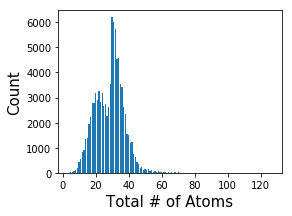

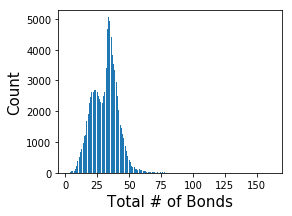

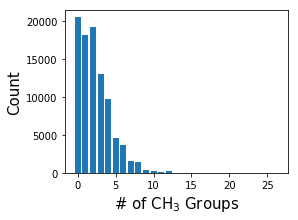

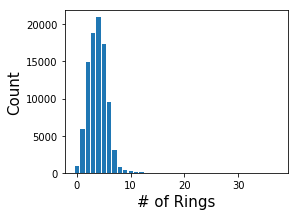

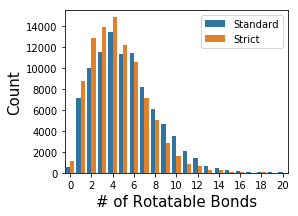

In [134]:
plt.figure(figsize=(4,3))
plt.bar(noatom,noatom_counts)
plt.ylabel("Count",size=15)
plt.xlabel("Total # of Atoms",size=15)
plt.show()

plt.figure(figsize=(4,3))
plt.bar(nobond,nobond_counts)
plt.ylabel("Count",size=15)
plt.xlabel("Total # of Bonds",size=15)
plt.show()


plt.figure(figsize=(4,3))
plt.bar(methyl,methyl_counts)
plt.ylabel("Count",size=15)
plt.xlabel(r"# of CH$_3$ Groups",size=15)
plt.show()


plt.figure(figsize=(4,3))
plt.bar(noring,noring_counts)
plt.ylabel("Count",size=15)
plt.xlabel("# of Rings",size=15)
plt.show()

plt.figure(figsize=(4,3))
sns.barplot(x="NumRotor",y="Count",data=rotors,hue="Type")
plt.legend(loc="upper right")
plt.ylabel("Count",size=15)
plt.xlabel("# of Rotatable Bonds",size=15)
plt.xticks(np.arange(0,21,2),labels=np.arange(0,21,2))
plt.show()



In [5]:
testdf = pd.read_csv("data/holdout.csv")
peptidedf = pd.read_csv("data/peptide.csv")

In [14]:
def FPBitVec( fps ):
    X = []
    for item in fps:
        bv = DataStructs.ExplicitBitVect(4096)
        DataStructs.ExplicitBitVect.FromBase64(bv, item)
        X.append(bv)
    return X

xtrain = FPBitVec(traindf.ECFP6)
xtest = FPBitVec(testdf.ECFP6)
xpeptide = FPBitVec(peptidedf.ECFP6)

train_test_max_similarity = [max(DataStructs.BulkTanimotoSimilarity(fps,xtrain)) for fps in xtest]
train_peptide_max_similarity = [max(DataStructs.BulkTanimotoSimilarity(fps,xtrain)) for fps in xpeptide]

In [122]:
plt.hist(train_test_max_similarity,bins=500)
plt.xlabel("Similarity",size=15)
plt.ylabel("Count",size=15)
plt.xticks([0,.2,.4,.6,.8,1])
plt.ylim(0,600)
plt.show()

plt.hist(train_peptide_max_similarity,bins=500)
plt.xlabel("Similarity",size=15)
plt.ylabel("Count",size=15)
plt.xticks([0,.2,.4,.6,.8,1])
plt.ylim(0,600)
plt.show()

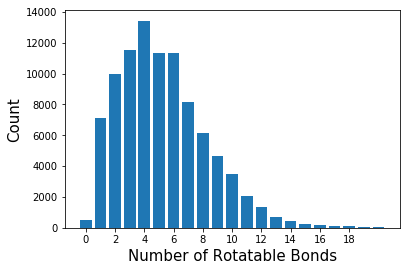

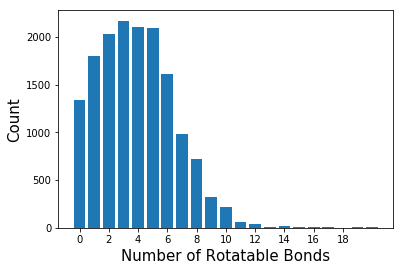

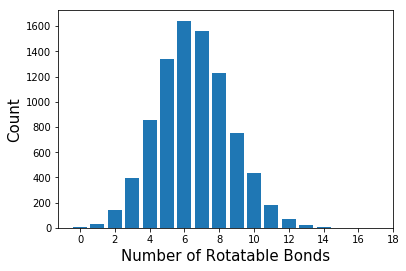

In [18]:
trainv, trainc = np.unique(traindf["NumRotors"], return_counts=True)
testv, testc = np.unique(testdf["NumRotors"], return_counts=True)
pepv,pepc = np.unique(peptidedf["NumRotors"], return_counts=True)

plt.bar(trainv, trainc)
plt.xticks(list(range(0,20,2)))
plt.ylabel("Count",size=15)
plt.xlabel("Number of Rotatable Bonds",size=15)
plt.show()


plt.bar(testv, testc)
plt.xticks(list(range(0,20,2)))
plt.ylabel("Count",size=15)
plt.xlabel("Number of Rotatable Bonds",size=15)
plt.show()


plt.bar(pepv, pepc)
plt.xticks(list(range(0,20,2)))
plt.ylabel("Count",size=15)
plt.xlabel("Number of Rotatable Bonds",size=15)
plt.show()

# Contribution of each component to standard molecular entropy

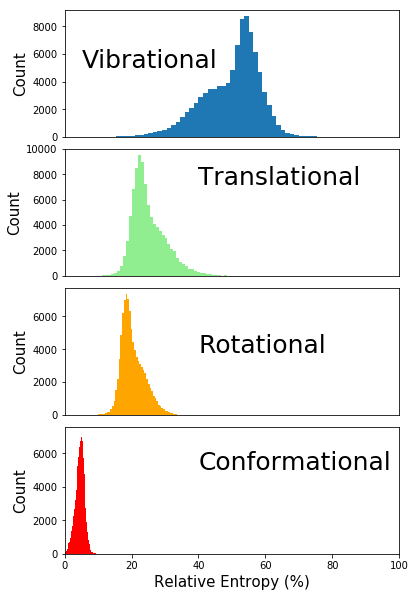

In [136]:
entropy_data= pd.read_csv("data/train_numconf.csv")

sconf = entropy_data[["entropy","vibEntropy","rotEntropy","transEntropy"]].sum(axis=1)
vib = entropy_data["vibEntropy"].div(sconf)*100
trans = entropy_data["transEntropy"].div(sconf)*100
rot = entropy_data["rotEntropy"].div(sconf)*100
conf = entropy_data["entropy"].div(sconf)*100


fig = plt.figure(figsize=(6,10),)
gs = gridspec.GridSpec(nrows=4, ncols=1, wspace=0.1, hspace=0.1)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

ax0.hist(vib,bins=50)
ax0.set_xlim(0,100)
ax2.set_xticks(np.arange(0,1,0.2))
ax0.get_xaxis().set_visible(False)
ax0.set_ylabel("Count",size=15)
plt.text(5,29000,"Vibrational",size=25)


ax1.hist(trans,bins=50, color="lightgreen")
ax1.set_xlim(0,100)
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("Count",size=15)
plt.text(40,22000,"Translational",size=25)


ax2.hist(rot,bins=50, color="orange")
ax2.set_xlim(0,100)
ax2.set_xticks(np.arange(0,1,0.2))
ax2.get_xaxis().set_visible(False)
ax2.set_ylabel("Count",size=15)
plt.text(40,12000,"Rotational",size=25)


ax3.hist(conf,bins=50,color="red")
ax3.set_xlim(0,100)
ax3.set_ylabel("Count",size=15)
plt.text(40,5000,"Conformational",size=25)
plt.xlabel("Relative Entropy (%)",size=15)
plt.show()


# Vibrational Entropy

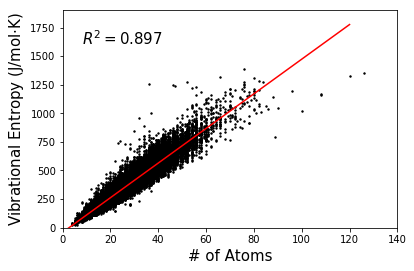

In [137]:
plt.scatter(entropy_data["numAtoms"],entropy_data["vibEntropy"],color="black",s=2)
plt.xlim(0,140)
plt.ylim(-1,1900)
plt.xlabel("# of Atoms",size=15)
plt.ylabel("Vibrational Entropy (J/mol$\cdot$K)",size=15)
plt.plot([0,120],[-40.75,1776],lw=1.5,color="red")
plt.text(8,1600,r"$R^{2}=0.897$",size=15)
plt.savefig("VibNatoms.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Computational Time

In [41]:
time = pd.read_csv("timing/combined-timings.csv")

In [60]:
conftime = time["crest-hour"]
vibtime = time["Seconds"]

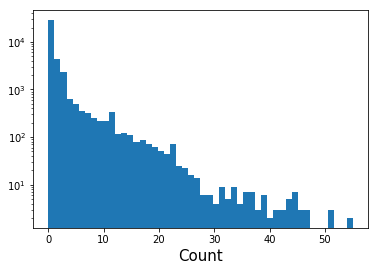

In [64]:
# CREST computational time
plt.hist(conftime,bins=50)
plt.yscale("log")
plt.xlabel("Conformer Ensembles (hrs)",size=15)
plt.xlabel("Count",size=15)
plt.show()

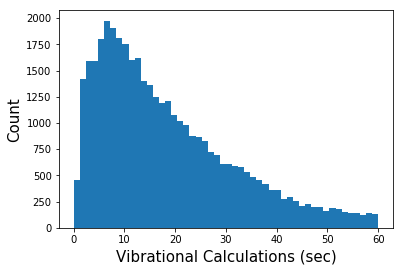

In [68]:
# Vibrational Entropy Calculation Time
plt.hist(vibtime,bins=50)
plt.xlabel("Vibrational Calculations (sec)",size=15)
plt.ylabel("Count",size=15)
plt.show()

In [121]:
cresttime = time["crest-second"].div(3600) + time["crest-min"].div(60) + time["crest-hour"]

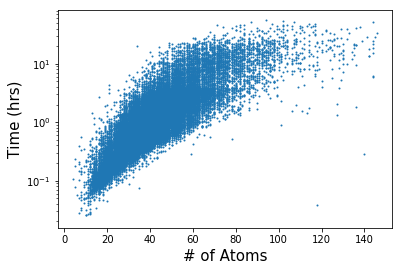

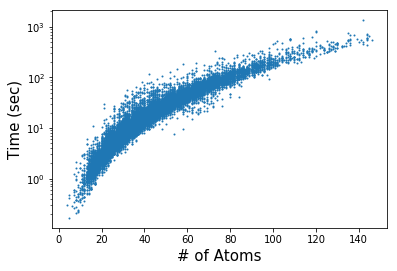

In [158]:
# CREST calculation time vs number of atoms
plt.scatter(time["NumAtoms"],x,s=1)
plt.yscale("log")
plt.ylabel("Time (hrs)",size=15)
plt.xlabel("# of Atoms",size=15)
plt.show()

# Vibrational calculation time vs number of atoms
plt.scatter(time["NumAtoms"],time["Time"],s=1)
plt.yscale("log")
plt.ylabel("Time (sec)",size=15)
plt.xlabel("# of Atoms",size=15)
plt.show()